# Q-learning
Since we now got an idea of what value function iteration is and since it works out beautifully, smoothly and concavely, we might wonder why we would ever think about doing anything else. Reinforcement learning (which is much more than what is described here, here we only the "easiest" way: Q-learning) is more general than value function iteration and needs less assumptions. For example:
1. We might not know the transition probabilities between exogenous shocks.
2. We might not even know the instantanious reward (the utility this period) we get, depending on the state and the action we take.
3. We might not need to find the value for all possible states, but might be happy to know good values for the states we visit during simulation. While this is not really an issue in the presented example, it *is* an issue when the state-space is huge. Like the possible positions on a Go board.

In that cases, we might want to  do fancy fancy Reinforcement Learning.
In the example below, the reinforcement learning agent, tries to find the optimal policy in a stochastic Ramsey model with two exogenous shocks, not knowing:
1. The production functions
2. The transition probabilities.

## 1 - How Q-learning works
The main object in Q-learning is the action-value function $Q$. $Q(x, u)$ denotes the value of a state (denoted by $x$) action (denoted by $u$) pair assuming that from the next period on, we will always take the best action. If we have an approximation of the action-value function (as opposed to the value function only), we know the best action to take in a given state without the need to know transition probabilities or the reward we get from consumption. Here we only do discrete action and discrete state. Having the $Q$ function, we can easily backout the value function
$$
V(x)=\text{arg}\max_u Q(x, u).
$$

The agent starts of with initial approximation of her Q-function. Here we take $Q^{\text{initial}}(x,u) = 0$ for all $x\in X,~u\in U$. Furthermore the agent has a discount factor $\gamma$ (`agent_gamma`), and an initial exploration probability $\epsilon$ (`agent_eps_start`) (which is decreased at rate $g^{\epsilon}$ (`agent_decr_eps`)) as well as a learning rate $\alpha$ (`agent_lr`). The agent then starts of in the environment and takes its next step according to
\begin{equation}
u(x) = 
\begin{cases}
\text{argmax}_{u}Q^{\text{current}}(x, u), &\text{with probability }1-\epsilon \\
u \in U \text{at random}, &\text{with probability }\epsilon
\end{cases}
\end{equation}
After taking the step, the agent observes the reward r (`r`), the next state $x'$ (`x_next`) and if the game has ended (`done`).
After each step, the agent then updates is Q-function according to:
\begin{equation}
Q^{\text{updated}}(x, u) = (1 - \alpha)Q^{\text{current}}(x, u) + \alpha \left(r + \gamma \max_{u'}Q^{\text{current}}(x', u')\right)
\end{equation}
Supsequently 
\begin{align}
Q^{\text{current}}(x, u)&=Q^{\text{updated}}(x, u)\\
\epsilon &= 
\begin{cases}
\epsilon, &\text{the first few iterations}\\
g^{\epsilon} \epsilon, &\text{eventually}
\end{cases}
\end{align}
Then (provided the game didn't end), the whole process is repeated for $x = x'$.
To monitor the learning process we look at the sum of discounted rewards (discountrate $\gamma$) along the simulated trajectories.
Note that we don't need any assumptions about the underlying world, $i.e.$ the economic model, to make those updates.
Algorithm could, essentially unchanged, solve chess.
## 2 - Implementation
This implementation is based on the coursera course practical RL (https://www.coursera.org/learn/practical-rl ).

In [1]:
from collections import defaultdict
import random

class QLearningRamseyAgent:
    def __init__(self, lr, eps, gamma, get_allowed_actions):

        self.get_allowed_actions = get_allowed_actions #function which returns the possible actions in a given state
        self.qvalues = defaultdict(lambda: defaultdict(lambda: 0)) # disctionaries storing the Q-values
        self.lr = lr # learning rate
        self.eps = eps # probability of random action
        self.gamma = gamma # discount factor

    def read_qvalue(self, state, action):
        # returns the q value for a state action pair
        return self.qvalues[tuple(state.tolist())][action]

    def assign_qvalue(self,state,action,value):
        # updates the q value
        self.qvalues[tuple(state.tolist())][action] = value

    def get_v_value(self, state):
        # gets the value function fot a specific state
        possible_actions = self.get_allowed_actions(state)

        #If there are no legal actions, return 0.0
        if len(possible_actions) == 0:
            return 0.0

        for i in range(len(possible_actions)):
            pos_action = possible_actions[i]
            if i == 0:
                q_max = self.read_qvalue(state, pos_action)
            else:
                if self.read_qvalue(state, pos_action) > q_max:
                    q_max = self.read_qvalue(state, pos_action)
            
        value = q_max
        return value

    def update_agent(self, state, action, reward, next_state):
        # makes a q-update
        
        q_updated = (1 - self.lr) * self.read_qvalue(state, action) \
        + self.lr * (reward + self.gamma * self.get_v_value(next_state))
        
        self.assign_qvalue(state, action, q_updated)

    
    def get_best_action(self, state):
        # returns the best action
        possible_actions = self.get_allowed_actions(state)
        
        for i in range(len(possible_actions)):
            pos_action = possible_actions[i]
            
            if i == 0:
                q_max = self.read_qvalue(state, pos_action)
                i_max = 0
            else:
                if self.read_qvalue(state, pos_action) > q_max:
                    i_max = i
                    q_max = self.read_qvalue(state, pos_action)
            
        return possible_actions[i_max]


    def get_ql_action(self, state):
        # Returns a random action with probability epilon and the best action otherwise
        possible_actions = self.get_allowed_actions(state)
        
        rn = np.random.rand()
        
        if rn < self.eps:
            chosen_action = random.choice(possible_actions)
        else:
            chosen_action = self.get_best_action(state)
        
        return chosen_action

In [6]:
import gym
import ramsey
import numpy as np
from matplotlib import pyplot as plt

env = gym.make("Ramsey-v0")

n_actions = env.action_space.n
print('number discrete actions: ', n_actions)

agent_lr = 0.01
agent_eps_start = 0.95
agent_gamma = 0.9
agent_decr_eps = 0.99999

klist = env.get_klist()
print('k - values corresponding to actions:', klist)

number discrete actions:  15
k - values corresponding to actions: [0.1        0.37857143 0.65714286 0.93571429 1.21428571 1.49285714
 1.77142857 2.05       2.32857143 2.60714286 2.88571429 3.16428571
 3.44285714 3.72142857 4.        ]


/home/marlon/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


In [7]:
agent = QLearningRamseyAgent(lr=agent_lr, eps=agent_eps_start, gamma=agent_gamma,
                       get_allowed_actions = lambda s: range(n_actions))

In [8]:
def simulate_and_update(env, agent, x_start, t_max=10):
    total_disc_reward = 0.0
    
    # start from random observation
    # print('x_start=', x_start)
    x = x_start
    env.reset(x)
    
    for t in range(t_max):
        # get agent to pick action given state s.
        u = agent.get_ql_action(x)
        
        next_x, r, done = env.step(u)
        
        # train (update) agent for state s
        agent.update_agent(x, u, r, next_x)
        
        x = next_x.copy()
        total_disc_reward += r * agent_gamma**t
        if done: break
        
    return total_disc_reward

i = 0 , eps = 0.95 , lr = 0.01 , mean disc reward (last 500) = -545316.0421345175


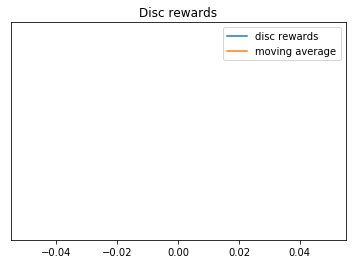

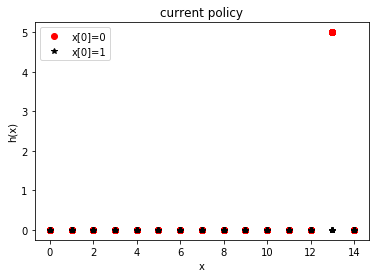

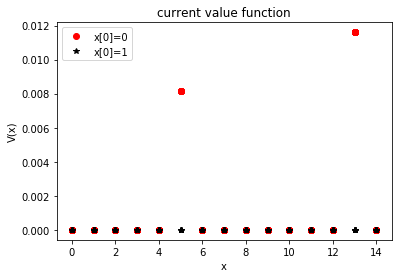

i = 100000 , eps = 0.95 , lr = 0.01 , mean disc reward (last 500) = -980623.5925614845


/home/marlon/anaconda3/lib/python3.6/site-packages/IPython/core/pylabtools.py:122: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


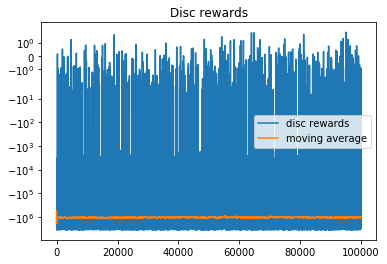

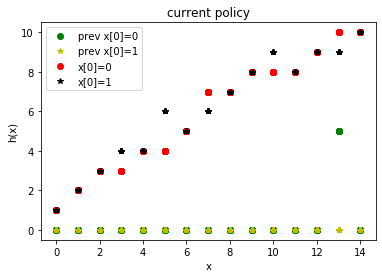

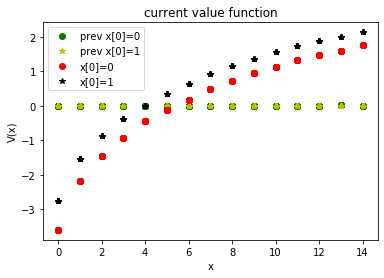

i = 200000 , eps = 0.95 , lr = 0.01 , mean disc reward (last 500) = -1065138.0643404308


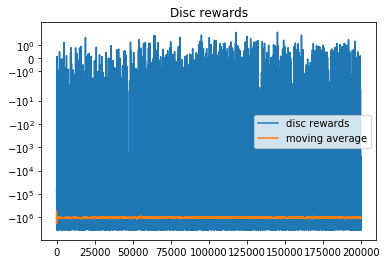

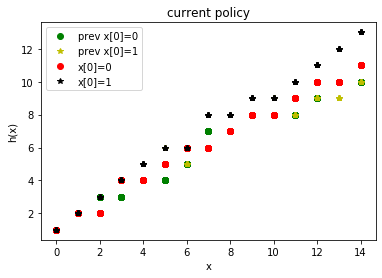

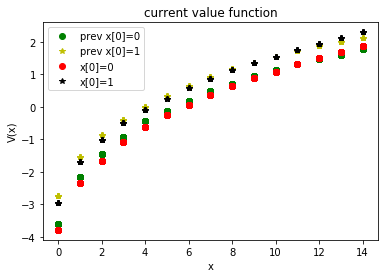

i = 300000 , eps = 0.95 , lr = 0.01 , mean disc reward (last 500) = -1030189.9004951905


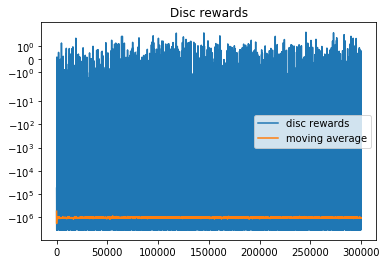

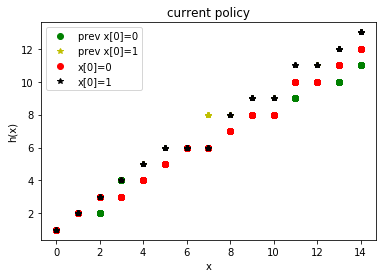

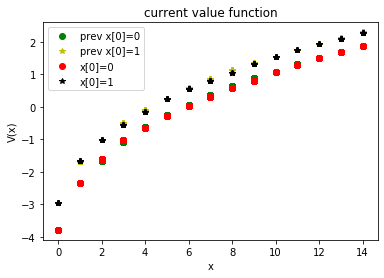

KeyboardInterrupt: 

In [9]:
disc_rewards = []
moving_average = []


for i in range(3*10**6):
    x_start = env.observation_space.sample()
    disc_rewards.append(simulate_and_update(env, agent, x_start))
    moving_average.append(np.mean(disc_rewards[-500:]))
    
    if i > 1 * 10**6:
        agent.eps *= agent_decr_eps
    
    if i %10 ** 5 == 0:
        
        plot_action_list = []
        plot_value_list = []
        plot_obs_list = []
        
        #clear_output(True)
        print('i =', i, ', eps =', agent.eps, ', lr =', agent.lr, ', mean disc reward (last 500) =', moving_average[-1])
        plt.title("Disc rewards")
        plt.plot(disc_rewards, label = 'disc rewards')
        plt.plot(moving_average, label = 'moving average')
        plt.yscale('symlog')
        plt.legend()
        plt.show()
        plt.close()
        
        for x in range(500):
            obs = env.observation_space.sample()
            u = agent.get_best_action(obs)
            v = agent.get_v_value(obs)
            plot_obs_list.append(obs)
            plot_action_list.append(u)
            plot_value_list.append(v)
        
        plot_obs_list = np.array(plot_obs_list)
        plot_value_list = np.array(plot_value_list)
        plot_action_list = np.array(plot_action_list)
        
            
        plt.figure()
        plt.title('current policy')
        if i > 0:
            plt.plot(plot_obs_list_old[plot_obs_list_old[:,0] == 0, 1], plot_action_list_old[plot_obs_list_old[:,0] == 0], 'go', label = 'prev x[0]=0')
            plt.plot(plot_obs_list_old[plot_obs_list_old[:,0] == 1, 1], plot_action_list_old[plot_obs_list_old[:,0] == 1], 'y*', label = 'prev x[0]=1')   
        plt.plot(plot_obs_list[plot_obs_list[:,0] == 0, 1], plot_action_list[plot_obs_list[:,0] == 0], 'ro', label = 'x[0]=0')
        plt.plot(plot_obs_list[plot_obs_list[:,0] == 1, 1], plot_action_list[plot_obs_list[:,0] == 1], 'k*', label = 'x[0]=1')
        plt.xlabel('x')
        plt.ylabel('h(x)')
        plt.legend()
        plt.show()
        plt.close()
        
        plt.figure()
        plt.title('current value function')
        if i > 0:
            plt.plot(plot_obs_list_old[plot_obs_list_old[:,0] == 0, 1], plot_value_list_old[plot_obs_list_old[:,0] == 0], 'go', label = 'prev x[0]=0')
            plt.plot(plot_obs_list_old[plot_obs_list_old[:,0] == 1, 1], plot_value_list_old[plot_obs_list_old[:,0] == 1], 'y*', label = 'prev x[0]=1')   
        plt.plot(plot_obs_list[plot_obs_list[:,0] == 0, 1], plot_value_list[plot_obs_list[:,0] == 0], 'ro', label = 'x[0]=0')
        plt.plot(plot_obs_list[plot_obs_list[:,0] == 1, 1], plot_value_list[plot_obs_list[:,0] == 1], 'k*', label = 'x[0]=1')
        plt.xlabel('x')
        plt.ylabel('V(x)')
        plt.legend()
        plt.show() 
        plt.close()
        
        
        plot_obs_list_old = plot_obs_list.copy()
        plot_value_list_old = plot_value_list.copy()
        plot_action_list_old = plot_action_list.copy()
